# Purpose

Make animation of layer-by-layer polymerization of a microfluidic device with a channel.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

# Colors

## Colormap code - decreasing alpha channel

In [2]:
def make_colormap_linearly_varying_alpha(color, N=256, alpha_small=0.0, alpha_high=1.0, reverse=True):
    """Create a colormap of a single color with linearly varying alpha channel.
    """
    
    assert isinstance(color, (list, tuple))
    assert len(color) == 3
    
    # Set up array for RGBA values
    vals_linear_alpha = np.ones((N, 4))

    # Fill 4th channel (alpha channel) with linearly varying values
    vals_linear_alpha[:, 3] = np.linspace(alpha_small, alpha_high, N)

    # Create array of 1 color with linearly varying alpha values
    temp = vals_linear_alpha * np.array([*color, 1.])

    # Turn array into colormap...
    cmap = ListedColormap(temp)
    # ...and possibly reverse it
    if reverse:
        cmap = cmap.reversed()
        
    return cmap


def make_colormap_exponentially_decaying_alpha(
    color, 
    num_one_over_e_distances=4, 
    N=256, 
    reverse=False
):
    """Create a colormap of a single color with exponentially decaying alpha channel.
    """
    
    assert isinstance(color, (list, tuple))
    assert len(color) == 3
    
    # Set up array for RGBA values
    vals_exp_alpha = np.ones((N, 4))

    # Fill 4th channel (alpha channel) with exponentially decaying values
    linear_values = np.linspace(0, num_one_over_e_distances, N)
    vals_exp_alpha[:, 3] = np.exp(-linear_values)

    # Create array of 1 color with linearly varying alpha values
    temp = vals_exp_alpha * np.array([*color, 1.])

    # Turn array into colormap...
    cmap = ListedColormap(temp)
    # ...and possibly reverse it
    if reverse:
        cmap = cmap.reversed()
        
    return cmap

## Colors

In [3]:
purple = (128/255, 0, 128/255)
ca = (73/255, 60/255, 255/255)  #493cff
cb = (171/255, 60/255, 255/255)  #ab3cff


## Linearly decreasing

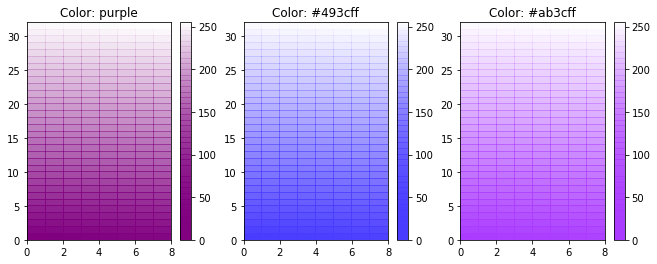

In [4]:
cmap_purple = make_colormap_linearly_varying_alpha(purple)
cmap_ca = make_colormap_linearly_varying_alpha(ca)
cmap_cb = make_colormap_linearly_varying_alpha(cb)
cmaps = [cmap_purple, cmap_ca, cmap_cb]
titles = ['purple', '#493cff', '#ab3cff']

data = np.linspace(0, 255, 256)
data = np.reshape(data, (32, 8))

%matplotlib inline

fig, axs = plt.subplots(figsize=(11, 4), ncols=len(cmaps))

for ax, cmap, title in zip(axs, cmaps, titles):
    psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=255)
    ax.set_title(f"Color: {title}")
    fig.colorbar(psm, ax=ax)

## Exponentially decreasing

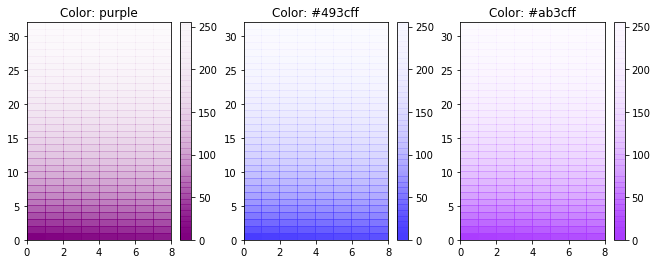

In [6]:
cmap_exp_purple = make_colormap_exponentially_decaying_alpha(purple)
cmap_exp_ca = make_colormap_exponentially_decaying_alpha(ca)
cmap_exp_cb = make_colormap_exponentially_decaying_alpha(cb)
cmaps = [cmap_exp_purple, cmap_exp_ca, cmap_exp_cb]
titles = ['purple', '#493cff', '#ab3cff']

data = np.linspace(0, 255, 256)
data = np.reshape(data, (32, 8))

fig, axs = plt.subplots(figsize=(11, 4), ncols=len(cmaps))

for ax, cmap, title in zip(axs, cmaps, titles):
    psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=255)
    ax.set_title(f"Color: {title}")
    fig.colorbar(psm, ax=ax)

# Gradient Rectangle

In [14]:
class GradientRectangle:
    """Quasi Rectangle patch using imshow.
    
    Creates an image of a single color with a vertical alpha gradient.
    
    Parameters
    ----------
    TBD
    
    Usage
    -----
    Instantiation without initial axes object
        gr = GradientRectangle(position=(0, 0), 
            width=10, height=30, 
            cmap=cmap)
        # Set axes object
        gr.set_ax(ax)
        # Turn on gr in plot
        gr.turn_on()
        
    Instantiation without initial axes object
        gr = GradientRectangle(position=(20, 10), 
                               width=40, 
                               height=50, #45*2.5, 
                               cmap=cmap, 
                               ax=ax,
                               npix_y=20,
                               zorder=20
                              )
        # Turn off gr in plot
        gr.turn_off()
        # Turn on gr in plot
        gr.turn_on()
        # Move by dx,dy
        x, y = gr.get_xy()
        gr.set_xy(x + dx, y + dy)
    
    
    """
    
    def __init__(self, position, width, height, cmap, ax=None, npix_x=20, npix_y=50, zorder=100):
        self._check_position(position)
        self.position = position
        self.width = width
        self.height = height
        self.cmap = cmap
        self.set_ax(ax)
        self._data = self._make_image(npix_x, npix_y)
        self.zorder = zorder
        self.img = None
        if self.ax:
            self.turn_on()
        
    def _make_image(self, npix_x, npix_y):
        temp = np.ones((npix_y, npix_x, 4))
        for i in range(temp.shape[0]):
            temp[i, :] *= self.cmap(int(i * 255/temp.shape[0]))
        return temp
    
    def _check_position(self, position):
        assert isinstance(position, (list, tuple))
        assert len(position) == 2
        
    
    def _to_extent(self):
        return (self.position[0],
                self.position[0] + self.width,
                self.position[1],
                self.position[1] + self.height
               )
    
    def _to_position_width_height(extent):
        self.position[0] = extent[0]
        self.position[1] = extent[2]
        # self.width = extent[0] + extent[1]
        # self.height = extent[2] + extent[3]
        
    def is_on(self):
        if self.img:
            return True
        return False
    
    def is_off(self):
        return not self.is_on()
        
    def turn_off(self):
        if self.is_on():
            self.img.remove()
            self.img = None
        
    def turn_on(self):
        if not self.ax:
            raise ValueError("'ax' needs to be set. See '.set_ax' method")
        if self.is_off():
            self.img = self.ax.imshow(self._data, 
                                 extent=self._to_extent(), 
                                 origin='lower',
                                 zorder=self.zorder
                                )
        
    def set_ax(self, ax):
        self.ax = ax
    
    def get_xy(self):
        return self.position
    
    def set_xy(self, new_position):
        self._check_position(new_position)
        self.position = new_position
        if self.ax:
            self.img.set_extent(self._to_extent())
        
        
gr = GradientRectangle(position=(0, 0), width=10, height=30, cmap=cmap_purple, ax=None)

# Make movie

50 30
CPU times: user 10.6 s, sys: 324 ms, total: 10.9 s
Wall time: 11 s


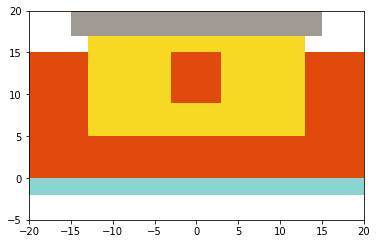

In [21]:
%%time

import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from matplotlib.patches import Rectangle

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=30, metadata=metadata)


# Colors
yellowish = (247/255, 216/255, 35/255, 1.0)
orangish = (226/255, 73/255, 12/255, 1.0)
lightblue = (140/255, 212/255, 210/255, 1.0)
grayish = (161/255, 154/255, 148/255, 1.0)


# Create Figure
fig = plt.figure()
ax = plt.gca()
ax.set_aspect('equal')

# Turn off axes frame, ticks, and labels
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
# ax.set_frame_on(False)


# Set up frame size and data coordinates
frame_width = 40
xmin, xmax = -frame_width / 2, frame_width / 2
ymin, ymax = -5, 20
x_size, y_size = xmax - xmin, ymin - ymax
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


# Background - make it white for now
background = Rectangle((xmin,ymin), x_size, y_size, facecolor=(1, 1, 1), edgecolor='none')
ax.add_patch(background)


# Glass window
glass_thickness = 2
glass_window = Rectangle((xmin,-glass_thickness), x_size, glass_thickness, facecolor=lightblue, edgecolor='none')
ax.add_patch(glass_window)


# Resin
resin_height = 15
resin = Rectangle((xmin, 0), x_size, resin_height, facecolor=orangish, edgecolor='none')
ax.add_patch(resin)


# Layer info
layer_thickness = 2
layer_width = 26
assert layer_width < frame_width
layer_x = -layer_width / 2
layer_y_init = 0


# Light info
# Put this before build platform so it is lower in zorder such that build platform will occlude it
# if they overlap
light_color_on = ca
light_color_off = 'none'
light_width = layer_width
light_x = -light_width / 2
light_y = ymin
light_height = -ymin
light_rectangle = Rectangle((light_x, light_y), light_width, light_height, 
                            facecolor=light_color_off, edgecolor='none')
light_patch = ax.add_patch(light_rectangle)
gr = GradientRectangle(position=(light_x, light_y + light_height), 
                       width=light_width, 
                       height=4, 
                       cmap=cmap_exp_ca, 
                       ax=ax,
                       npix_y=20,
                       zorder=20
                      )
gr.turn_off()

# Build platform
bp_margin = 5
bp_width = x_size - 2 * bp_margin
assert bp_width > layer_width
bp_height = 15 #y_size
bp_x = xmin + bp_margin
bp_y = layer_thickness
build_platform = Rectangle((bp_x, bp_y), bp_width, bp_height, facecolor=grayish, edgecolor='none')
ax.add_patch(build_platform)


# List to keep track of all of the parts that move with the build platform
# (i.e., the build platform itself and a growing number of layers as a print proceeds)
# Each element in the list can be an individual patch or a list of patches.
moving_parts = []
moving_parts.append(build_platform)


# Layer motion
up_distance = 5
delta_y = 0.1
n_up = int(up_distance / delta_y)
n_down = int((up_distance - layer_thickness) / delta_y)
print(n_up, n_down)


def ensure_it_is_a_list(some_element):
    if not isinstance(some_element, list):
        return [some_element]
    else:
        return some_element


def move_moving_parts(dx=0, dy=0):
    for mp in moving_parts:
        mp = ensure_it_is_a_list(mp)
#         if not isinstance(mp, list):
#             mp = [mp]
        for p in mp:
            x, y = p.get_xy()
            p.set_xy([x + dx, y + dy])
    
    
def move(n, direction):
    assert direction in ['up', 'down']
    sign = 1 if direction == 'up' else -1
    for i in range(n):
        move_moving_parts(0, sign*delta_y)
        writer.grab_frame()
        
        
def create_homogeneous_resin_layer():
    layer = Rectangle((layer_x, layer_y_init), layer_width, layer_thickness, 
                      facecolor=yellowish, edgecolor='none')
    ax.add_patch(layer)
    moving_parts.append(layer)
        
        
def create_channel_resin_layer(chan_width=6):
    layer_patches = []
    left = Rectangle((layer_x, layer_y_init), 
                      (layer_width - chan_width) / 2, layer_thickness, 
                      facecolor=yellowish, edgecolor='none')
    layer_patches.append(left)
    right = Rectangle((chan_width / 2, layer_y_init), 
                      (layer_width - chan_width) / 2, layer_thickness, 
                      facecolor=yellowish, edgecolor='none')
    layer_patches.append(right)
    for patch in layer_patches:
        ax.add_patch(patch)
    moving_parts.append(layer_patches)

    
def gradual_resin_layer_exposure(num_frames):
    alphas = np.linspace(0, 1, num=num_frames)
    patches = ensure_it_is_a_list(moving_parts[-1])
    if not isinstance(patches, list):
        patches = [patches]
    for alpha in alphas:
        for patch in patches:
            color = list(patch.get_facecolor())
            color[3] = alpha
            patch.set_facecolor(color)
        writer.grab_frame()

    
with writer.saving(fig, "movie_dev6.mp4", 100):
    writer.grab_frame()
    # 1/3 second pause
    for i in range(10):
        writer.grab_frame()
    
    num_layers = 6
    channel_layers = [1, 2, 3]
    
    for i_layer in range(num_layers):
        if i_layer in channel_layers:
            create_channel_resin_layer()
        else:
            create_homogeneous_resin_layer()
            
        # Inspect layer just created and create corresponding
        # light patches for each patch in the layer
        
        light_patch.set_facecolor(light_color_on)
        gr.turn_on()
        gradual_resin_layer_exposure(30)
        light_patch.set_facecolor(light_color_off)
        gr.turn_off()
        move(n_up, 'up')
        if i_layer != num_layers - 1:
            move(n_down, 'down')


# Make movie - patterned light

50 30
CPU times: user 10.9 s, sys: 301 ms, total: 11.2 s
Wall time: 11.3 s


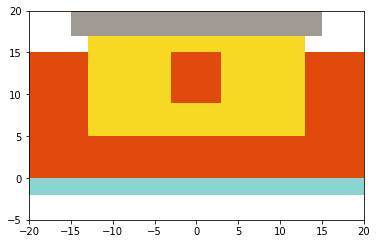

In [24]:
%%time

import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from matplotlib.patches import Rectangle

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=30, metadata=metadata)


# Colors
yellowish = (247/255, 216/255, 35/255, 1.0)
orangish = (226/255, 73/255, 12/255, 1.0)
lightblue = (140/255, 212/255, 210/255, 1.0)
grayish = (161/255, 154/255, 148/255, 1.0)


# Create Figure
fig = plt.figure()
ax = plt.gca()
ax.set_aspect('equal')

# Turn off axes frame, ticks, and labels
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
# ax.set_frame_on(False)


# Set up frame size and data coordinates
frame_width = 40
xmin, xmax = -frame_width / 2, frame_width / 2
ymin, ymax = -5, 20
x_size, y_size = xmax - xmin, ymin - ymax
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


# Background - make it white for now
background = Rectangle((xmin,ymin), x_size, y_size, facecolor=(1, 1, 1), edgecolor='none')
ax.add_patch(background)


# Glass window
glass_thickness = 2
glass_window = Rectangle((xmin,-glass_thickness), x_size, glass_thickness, facecolor=lightblue, edgecolor='none')
ax.add_patch(glass_window)


# Resin
resin_height = 15
resin = Rectangle((xmin, 0), x_size, resin_height, facecolor=orangish, edgecolor='none')
ax.add_patch(resin)


# Layer info
layer_thickness = 2
layer_width = 26
assert layer_width < frame_width
layer_x = -layer_width / 2
layer_y_init = 0


# Light info - uniform image
# Put this before build platform so it is lower in zorder such that build platform will occlude it
# if they overlap
thickness_decreasing_light = 4
light_color_on = ca
light_color_on_cmap = cmap_exp_ca
light_color_off = 'none'
light_width = layer_width
light_x = -light_width / 2
light_y = ymin
light_height = -ymin
light_rectangle = Rectangle((light_x, light_y), light_width, light_height, 
                            facecolor=light_color_off, edgecolor='none')
light_patch = ax.add_patch(light_rectangle)
gr = GradientRectangle(position=(light_x, light_y + light_height), 
                       width=light_width, 
                       height=thickness_decreasing_light, 
                       cmap=light_color_on_cmap, 
                       ax=ax,
                       npix_y=20,
                       zorder=20
                      )
gr.turn_off()


# Light info - channel image
chan_width = 6
left_light_patch = Rectangle((light_x, light_y), 
                  (light_width - chan_width) / 2, light_height, 
                  facecolor='none', edgecolor='none')
right_light_patch = Rectangle((chan_width / 2, light_y), 
                  (light_width - chan_width) / 2, light_height, 
                  facecolor='none', edgecolor='none')
ax.add_patch(left_light_patch)
ax.add_patch(right_light_patch)
left_gr = GradientRectangle(position=(light_x, light_y + light_height), 
                       width=(light_width - chan_width) / 2, 
                       height=thickness_decreasing_light, 
                       cmap=light_color_on_cmap, 
                       ax=ax,
                       npix_y=20,
                       zorder=20
                      )
left_gr.turn_off()
right_gr = GradientRectangle(position=(chan_width / 2, light_y + light_height), 
                       width=(light_width - chan_width) / 2, 
                       height=thickness_decreasing_light, 
                       cmap=light_color_on_cmap, 
                       ax=ax,
                       npix_y=20,
                       zorder=20
                      )
right_gr.turn_off()



# Build platform
bp_margin = 5
bp_width = x_size - 2 * bp_margin
assert bp_width > layer_width
bp_height = 15 #y_size
bp_x = xmin + bp_margin
bp_y = layer_thickness
build_platform = Rectangle((bp_x, bp_y), bp_width, bp_height, facecolor=grayish, edgecolor='none')
ax.add_patch(build_platform)


# List to keep track of all of the parts that move with the build platform
# (i.e., the build platform itself and a growing number of layers as a print proceeds)
# Each element in the list can be an individual patch or a list of patches.
moving_parts = []
moving_parts.append(build_platform)


# Layer motion
up_distance = 5
delta_y = 0.1
n_up = int(up_distance / delta_y)
n_down = int((up_distance - layer_thickness) / delta_y)
print(n_up, n_down)


def ensure_it_is_a_list(some_element):
    if not isinstance(some_element, list):
        return [some_element]
    else:
        return some_element


def move_moving_parts(dx=0, dy=0):
    for mp in moving_parts:
        mp = ensure_it_is_a_list(mp)
#         if not isinstance(mp, list):
#             mp = [mp]
        for p in mp:
            x, y = p.get_xy()
            p.set_xy([x + dx, y + dy])
    
    
def move(n, direction):
    assert direction in ['up', 'down']
    sign = 1 if direction == 'up' else -1
    for i in range(n):
        move_moving_parts(0, sign*delta_y)
        writer.grab_frame()
        
        
def create_homogeneous_resin_layer():
    layer = Rectangle((layer_x, layer_y_init), layer_width, layer_thickness, 
                      facecolor=yellowish, edgecolor='none')
    ax.add_patch(layer)
    moving_parts.append(layer)
        
        
def create_channel_resin_layer(chan_width=chan_width):
    layer_patches = []
    left = Rectangle((layer_x, layer_y_init), 
                      (layer_width - chan_width) / 2, layer_thickness, 
                      facecolor=yellowish, edgecolor='none')
    layer_patches.append(left)
    right = Rectangle((chan_width / 2, layer_y_init), 
                      (layer_width - chan_width) / 2, layer_thickness, 
                      facecolor=yellowish, edgecolor='none')
    layer_patches.append(right)
    for patch in layer_patches:
        ax.add_patch(patch)
    moving_parts.append(layer_patches)

    
def gradual_resin_layer_exposure(num_frames):
    alphas = np.linspace(0, 1, num=num_frames)
    patches = ensure_it_is_a_list(moving_parts[-1])
    if not isinstance(patches, list):
        patches = [patches]
    for alpha in alphas:
        for patch in patches:
            color = list(patch.get_facecolor())
            color[3] = alpha
            patch.set_facecolor(color)
        writer.grab_frame()


# Create movie
with writer.saving(fig, "movie_dev7.mp4", 100):
    writer.grab_frame()
    # 1/3 second pause
    for i in range(10):
        writer.grab_frame()
    
    num_layers = 6
    channel_layers = [1, 2, 3]
    
    for i_layer in range(num_layers):
        
        # Choose layer type and associated exposure light
        if i_layer in channel_layers:
            create_channel_resin_layer()
            left_light_patch.set_facecolor(light_color_on)
            right_light_patch.set_facecolor(light_color_on)
            left_gr.turn_on()
            right_gr.turn_on()
        else:
            create_homogeneous_resin_layer()
            light_patch.set_facecolor(light_color_on)
            gr.turn_on()
            
        # Resin exposure
        gradual_resin_layer_exposure(30)
        
        # Make sure all light is turned off
        light_patch.set_facecolor(light_color_off)
        gr.turn_off()
        left_light_patch.set_facecolor(light_color_off)
        right_light_patch.set_facecolor(light_color_off)
        left_gr.turn_off()
        right_gr.turn_off()
        
        move(n_up, 'up')
        if i_layer != num_layers - 1:
            move(n_down, 'down')


# Next

- Light
    - Add exponentially decaying light into material
    - Make mechanism for all light elements to turn on and off together
    - Needs to be patterned properly for each layer pattern
        - Need info that says what should be patterned in a layer, and use that info to determine both the light and the resin polymerization regions
- Put a top on the build platform
- Remove ticks and tick labels
- Use plt.tight?
- Make frame region bigger so have bigger video area
- Increase size of components
- Decrease build platform movement time
- Put text labels on things
- Label each layer?
- Increase dpi of output video
    